In [1]:
__author__ = "Lisa Tomasetto"
__copyright__ = "Copyright 2022, UGA"
__credits__ = ["Lisa Tomasetto"]
__version__ = "1.0"
__maintainer__ = "Lisa Tomasetto"
__email__ = "lisa.tomasetto@univ-grenoble-alpes.fr"
__status__ = "Production"

In [2]:
## Imports

# Distributed python packages
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import radians, log
import ipywidgets as widgets
import cartopy.crs as ccrs

# Own librairies
from source_microseism import main, plot_spectrogram, plot_global_source, plot_local_source

# Rayleigh Source of microseisms

This program aims at modelizing the ambient noise source in the secondary microseismic range for Rayleigh waves.
It is based on Ardhuin et al. (2011) article.

## Power Spectrum of the Vertical Displacement
We will compute the **equivalent source for the power spectrum of the vertical displacement** $S_{DF}$, its unit is meter times seconds.
$$ S_{DF}(f_s) \approx \frac{2\pi f_s C}{\rho_s^2 \beta^5} F_{p3D}(k_2 \approx 0, f_s)$$ 
where:
- $f_s$ is the seismic frequency (twice the ocean wave frequency)
- C is the amplitude response functions for the normal modes, from Longuet-Higgins (1950). $C = \sum_{i=1}^{4} c_i^2$
- $\rho_s$ is the rock density of the crust. Here $\rho_s = 2830 kg.m^{-3}$
- $\beta$ is the shear wave velocity. Here $\beta = 2.8 km.s^{-1}$
- $F_{p3D}(k_2 \approx 0, f_s)$ the spectral density of the pressure field at the ocean surface or directional wave spectra.

The values of the Rayleigh waves site effect coefficient can be found in Longuet-Higgins (1950), the values are tabulated in longuet_higgins.txt file.
The $F_{p3D}$ can be retrieved using oceanic waves model resources from the Ifremer institute in Brest, France.

## Power Spectrum of the Vertical Ground Displacement at a given seismic station

From the global noise source $S_{DF}(f)$, we will compute the power spectrum of the vertical ground displacement $F_{\delta}(\lambda, \phi, f)$ at a station of latitude $\lambda$ and longitude $\phi$. This value is frequency dependent so we will use the unintegrated $S_{DF}(f)$ value and display integrated $ F_{\delta}$. Some strong hypothesis on the propagation of Rayleigh waves between the source and the given station: 
- vertically symmetric earth model
- no 3D propagation effect
- uniform Q

The value of Q is a parameter, however some tabulated values are available.
$$ F_{\delta}(\lambda, \phi, fs) = \int_{\lambda_m}^{\lambda_{m+1}} \int_{\phi_n}^{\phi_{n+1}} \frac{S_{DF}(f)}{R_E \sin\Delta} e^{\frac{-2\pi f \Delta R_E}{UQ}} R_E^2 \sin \phi' d\lambda' d\phi' $$
where:
- $\lambda$ is the latitude of the station
- $\phi$ is the longitude of the station
- $\lambda_m$ and $\phi_n$ the coordinates of the grid point 
- $R_E$ is the Earth radius
- U is the seismic group velocity. Here $U = 1.8 km.s^{-1}$
- Q is the attenuation factor. It varies with location, we give some examples in the code.
- $\Delta$ is the distance of the point integrated to the station

References: 
* Ardhuin, F., Stutzmann, E., Schimmel, M., & Mangeney, A. (2011). Ocean wave sources of seismic noise. Journal of Geophysical Research: Oceans, 116(C9).
* Longuet-Higgins, M. S. (1950). A theory of the origin of microseisms. Philosophical Transactions of the Royal Society of London. Series A, Mathematical and Physical Sciences, 243(857), 1-35.

In [3]:
## Set font size parameters to make readable figures
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Parameters

This implementation is depending on a few parameters. Some are described above in the formula of our rayleigh wave noise source but others are for the user to choose.

The first set of parameters is the physical constants above. 
The plot variable allows you to plot monthly source or not. For particular events set to False.
Then the dates the user wants to focus on, loops on hours, days, months and years are available setting an empty bracket symbol.

Then the different paths for the bathymetry files, Longuet-Higgins values of site effect file, files from the WW3 Hindcast data wave model. 
    For the model files go to ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/, then choose the year(s) and month(s) corresponding files. Two files are necessary, the significant waveheight file, extension hs.nc and the directional wave spectra file, extension p2l.nc. 
Finally the user can choose the extent of the maps with minimum and maximum longitudes and latitudes.

In [4]:
##Parameters for ocean site effect maps and rayleigh noise sources

# seismic waves
vs_crust = 2.8  # km/s
rho_s = 2830  # kg/m3
f1 = 1/12  # frequency to integrate from
f2 = 1/5  # frequency to integrate to
res_mod = radians(0.5)  # angular resolution of the model
radius = 6.371*1e6
lg10 = log(10)
plot = False # plot PSD integrated over frequency

# dates
YEAR = 2020   # loop if vector
MONTH = [9]  # loop if vector
DAY =  [18] # loop if vector, compute all days of the month if empty
HOUR = []  # loop if vector

# ww3
file_bathy = "ww3.07121700.dpt"
#fpath = './' 
fpath = '/Users/tomasetl/Documents/code/ocean_source/data/2020/'
# site effect
path = './longuet_higgins.txt'
# extent
lat_min = 30
lat_max = 60
lon_min = -10
lon_max = 50

# azimuthal distribution
U = 1800  # seismic group velocity m/s
Q = {'KIP': 580, 'BORG': 180, 'BKS': 88, 'SSB': 260}
"""attenuation factor used in Ardhuin et al. (2011) for 
KIP (Hawaii) few reflections old crust,
BORG (Iceland) few reflection young crust,
BKS (California USA),
SSB (France) respectively"""
key = 'SSB'
lat_sta, lon_sta = 45.279, 4.542

## Bathymetry file 
   The bathymetry (or waterlevel) is necessary to compute the site effect for a given phase. Here we use the file "ww3.07121700.dpt" available on Ifremer ftp (ftp.ifremer.fr)
   The resolution of our maps is 0.5° in latitude and 0.5° in longitude. The dimension of dpt1 matrix should be 720x323 (longitude x latitude). For years after 2017 (included) the model format is 720x317 (longitude x latitude) the last 3° of latitude are not calculated so the dpt1 matrix shape has to be adapted.

### Download data

In [5]:
path_to_files = "ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_%s_REF102040"%YEAR

for m in MONTH:
    if m < 10:
        file_p2l = path_to_files + "/WW3-GLOB-30M_%s0%d_p2l.nc"%(YEAR, m)
    else:
        file_p2l = path_to_files + "/WW3-GLOB-30M_%s%d_p2l.nc"%(YEAR, m)
    print("wget -r -c %s"%(file_p2l))

os.system("wget -r -c %s"%(file_p2l))

wget -r -c ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2020_REF102040/WW3-GLOB-30M_202009_p2l.nc


--2022-11-17 18:03:37--  ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2020_REF102040/WW3-GLOB-30M_202009_p2l.nc
           => 'ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2020_REF102040/.listing'
Resolving ftp.ifremer.fr (ftp.ifremer.fr)... 134.246.142.21
Connecting to ftp.ifremer.fr (ftp.ifremer.fr)|134.246.142.21|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2020_REF102040 ... done.
==> PASV ... done.    ==> LIST ... done.

     0K .......                                                 248K=0.03s

2022-11-17 18:03:37 (248 KB/s) - 'ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2020_REF102040/.listing' saved [7252]

Removed 'ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2020_REF102040/.listing'.
--2022-11-17 18:03:37--  ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2020_REF102040/WW3-GLOB-30M_202009_p2l.nc
           => 'ftp.

0

## Main function
The main function takes as entry the parameters written above and creates a Pandas dataframe with for each time step:
- the date
- the frequency range
- $SDF(f)$ value for each frequency
- $F_{delta}(f)$ 

In [6]:
print(os.path.abspath(''))
os.chdir(os.path.abspath(''))

/Users/tomasetl/Documents/code/ocean_source/pr_oceanswell/rayleigh


In [7]:
jsonpath="data2020_9_18.json"
if os.path.isdir(jsonpath):  
    print("\nIt is a directory")  
elif os.path.isfile(jsonpath):  
    print("File already there !")
    df = pd.read_json(path_or_buf = jsonpath, orient = "columns")
else:
    print("json file not calculated ... Let's do it")
    print("It takes some time")
    df = main(file_bathy, fpath, path, lat_min, lat_max, lon_min, lon_max, U, key, YEAR, MONTH, DAY, HOUR)

json file not calculated ... Let's do it
It takes some time
no exception
/Users/tomasetl/Documents/code/ocean_source/data/2020/WW3-GLOB-30M_202009_p2l.nc
DONE ! Filename: data2020_9_18.json


In [8]:
zlon = np.arange(-180, 180, 0.5) # longitude vector of the model
zlat = np.arange(-78, 80.5, 0.5) # latitude vector of the model
date = df["date"].to_numpy() # date vector
freq = (df["fq"].to_numpy())[0] # frequency range of the model

## Spectrogram
The following cell creates a spectrogram at the station with coordinates (lat_sta, lon_sta) and attenuation factor Q given in the parameters cell.

The spectrogram is calculated as a spectrogram of the RMS of the vertical displacement.
At a given time step it is calculated as follows:
$$ 10 \log \sqrt{\sum_{\lambda} \sum_{\phi} F_{\delta}(\lambda, \phi, f_s)}$$

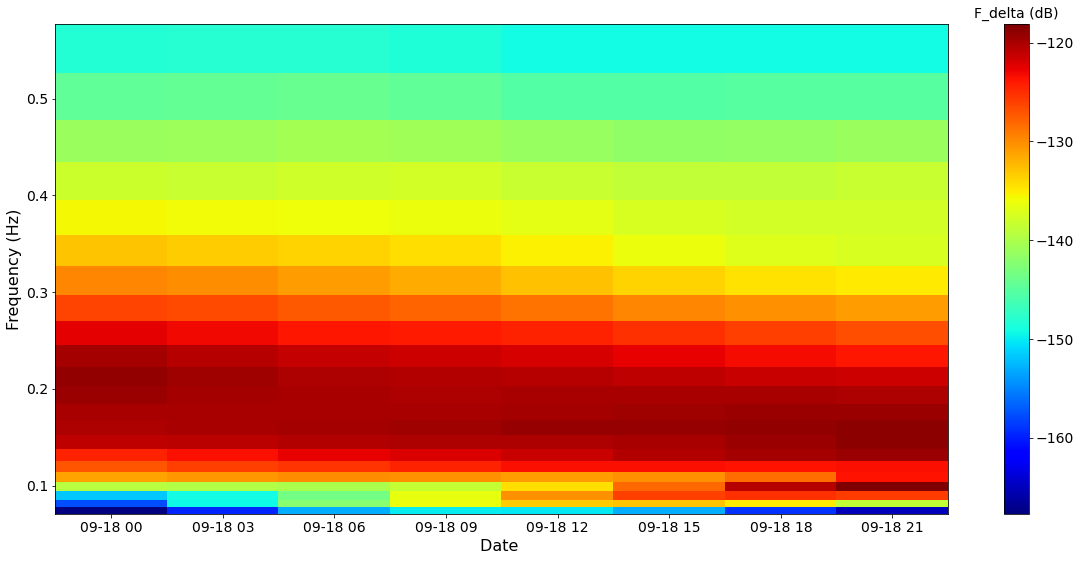

In [9]:
disp = np.stack(np.squeeze(df["disp"].to_numpy()))

plot_spectrogram(date, freq, disp)

## Frequency and time dependent plot
Plot of $SDF(f_s)$ and $F_{\delta}(\lambda, \phi, f_s)$.

In [10]:
time = date[0]
f = 0.15

### Plot SDF

In [11]:
def plot_global_source(f_idx = 0, t_idx = 1):
    dt = date[t_idx]
    SDF = np.squeeze(np.squeeze(df[df["date"]==dt]["source_global"]))[:, :, f_idx]
    SDF = SDF.astype('float64')
    plt.figure(figsize = (15, 8))
    ax = plt.axes(projection = ccrs.PlateCarree())
    ax.coastlines()
    im = ax.pcolor(zlon, zlat, SDF, cmap='jet', shading='auto')
    ax.set_title('Source of the power spectrum for the vertical displacement.\n Rayleigh waves. Frequency %.3f Hz\n %s'%(freq[f_idx], date[t_idx]))
    plt.colorbar(im, label = 'SDF (m.s)', orientation = 'horizontal', ax=ax)
    #ax.set_extent((lon_min, lon_max, lat_min, lat_max))
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

In [12]:
widgets.interact(plot_global_source, f_idx =(0, len(freq), 1), t_idx = (0, len(date), 1))

interactive(children=(IntSlider(value=0, description='f_idx', max=22), IntSlider(value=1, description='t_idx',…

<function __main__.plot_global_source(f_idx=0, t_idx=1)>

## Plot $F_{\delta}$

In [13]:
def plot_local_source(f_idx = 0, t_idx = 0):
    dt = date[t_idx]
    dad = np.squeeze(np.squeeze(df[df["date"]==dt]["source_local"]))[:, :, f_idx]
    dad = dad.astype('float64')
    # F_delta in meters square
    plt.figure(figsize = (15, 8))
    ax = plt.axes(projection = ccrs.NearsidePerspective(central_longitude=lon_sta, central_latitude=lat_sta))
    ax.coastlines()
    im = ax.pcolor(zlon, zlat, dad, cmap='jet', transform = ccrs.PlateCarree(), shading='auto')
    ax.set_title('Contribution of sources to power spectrum of vertical displacement at station.\n Rayleigh waves. Frequency %.3f Hz \n %s'%(freq[f_idx], dt))
    plt.colorbar(im, label = '', orientation = 'horizontal', ax=ax)
    ax.plot(lon_sta, lat_sta, 'r+', transform = ccrs.PlateCarree(), label='Station')
    #ax.set_extent((lon_min, lon_max, lat_min, lat_max))
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

In [14]:
widgets.interact(plot_local_source, f_idx =(0, len(freq), 1), t_idx = (0, len(date), 1))

interactive(children=(IntSlider(value=0, description='f_idx', max=22), IntSlider(value=0, description='t_idx',…

<function __main__.plot_local_source(f_idx=0, t_idx=0)>